In [1]:
import logging
import pandas as pd
import geopandas
import eust
import matplotlib as mpl
import matplotlib.pyplot as plt
import hierarchy
import nuts
import settings
import plotting

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set some constants

## Exclude data with some flags

In [2]:
eust.read_table_metadata('ef_lus_allcrops')['attributes']

label
attribute  code                                                      
OBS_FLAG   OBS_FLAG                                 Observation flag.
           b                                     break in time series
           c                                             confidential
           d                         definition differs, see metadata
           e                                                estimated
           f                                                 forecast
           i                                see metadata (phased out)
           n                                          not significant
           p                                              provisional
           r                                                  revised
           s                           Eurostat estimate (phased out)
           u                                          low reliability
           z                                           not applicable
OBS_STATUS OBS_STATUS                             Observation status.
           -           not applicable or real zero or zero by default
           0                          less than half of the unit used
           na                                           not available

In [3]:
# Eurostat data flags where to drop the data
EXCLUDED_FLAGS = ['u']

## Read NUTS nomenclature data

In [4]:
NUTS_TABLE = nuts.get_nuts_candidates()
EU28_COUNTRIES = NUTS_TABLE.country_code.unique()
NUTS_TABLE

,country_code,nuts_level,label,parent_geo,country
geo,,,,,
AT,AT,0,ÖSTERREICH,NaN,Austria
AT1,AT,1,OSTÖSTERREICH,AT,Austria
AT11,AT,2,Burgenland (AT),AT1,Austria
AT12,AT,2,Niederösterreich,AT1,Austria
AT13,AT,2,Wien,AT1,Austria
...,...,...,...,...,...
UKM3,UK,2,South Western Scotland,UKM,United Kingdom
UKM5,UK,2,North Eastern Scotland,UKM,United Kingdom
UKM6,UK,2,Highlands and Islands,UKM,United Kingdom


# Crop production calculation

In [5]:
CROP_PARTITIONS = {
    'UAA': ['ARA', 'J0000', 'PECR', 'K0000'],
    'PECR': ['H0000', 'L0000', 'PECR9'],
    'ARA': ['C0000', 'P0000', 'R0000', 'I0000', 'G0000', 'V0000_S0000', 'ARA9', 'Q0000'],
    'C0000': ['C1000', 'C2000'],
    'C1000': ['C1000X1500', 'C1500'],
    'C1000X1500': ['C1100', 'C1200', 'C1300', 'C1400', 'C1600_1700_1900'],
    'C1600_1700_1900': ['C1600', 'C1700', 'C1900'],
    'C2000': ['C2100', 'C2200'],
    'C1100': ['C1110', 'C1120'],
    'C1110': ['C1111', 'C1112'],
    'C1200': ['C1210', 'C1220'],
    'C1300': ['C1310', 'C1320'],
    'C1400': ['C1410', 'C1420'],
    'I0000': ['I1100','I2000','I3000','I4000','I5000','I6000_9000'],
    'I1100': ['I1110-1140', 'I1150', 'I1190'],
    'I1110-1140': ['I1110-1130', 'I1140'],
    'I1110-1130': ['I1110', 'I1120', 'I1130'],
    'P0000': ['P1000', 'P9000'],
    'P1000': ['P1100', 'P1200', 'P1300'],
    'R0000': ['R1000', 'R2000', 'R9000'],
    'J0000': ['J1000', 'J2000', 'J3000'],
    'J3000': ['J3000ES',],
    'G0000': ['G1000', 'G2000', 'G3000', 'G9000'],
    'G2000': ['G2100','G2900'],
    'G9000': ['G9100','G9900'],
    'H0000': ['F0000', 'T0000', 'W1000', 'O1000', 'H9000'],
    'W1000': ['W1100', 'W1200', 'W1300', 'W1900'],
    'W1100': ['W1110_1120', 'W1190'],
    'W1110_1120': ['W1110', 'W1120'],
    'O1000': ['O1100', 'O1900'],
    'O1900': ['O1910', 'O1990'],
    'T0000': ['T1000', 'T2000', 'T3000', 'T4000', 'T9000'],
}

## Load and transform P contents for crops and subcrops

In [6]:
P_CONTENT = pd.read_csv(settings.P_CONTENT_PATH)
P_CONTENT

,Crop code,Crop,Basis,P content [g/kg],P2O5 content [g/kg],Source
0,C1000X1500,Cereals except maize and rice,DM,3.6,NaN,Feedipedia (wheat grain)
1,C1500,Grain maize,DM,3.0,NaN,Feedipedia (grain maize)
2,C2000,Rice,FW,NaN,6.7,IPNI (2014)
3,G1000,Temporary grassland,DM,NaN,5.8,"IPNI (2014), average ryegrass and timothy"
4,J0000,Permanent grassland,DM,NaN,5.8,"IPNI (2014), average ryegrass and timothy"
5,G2000,Leguminous plants harvested green,DM,3.1,NaN,"Feedipedia (red clover, alfalfa mean)"
6,G3000,Green maize,DM,1.9,NaN,Feedipedia (maize silage)
7,G9000,Other crops harvested green,DM,2.5,NaN,"Mean of G1000, G2000, G3000"
8,I1110,Rapeseed,DM,7.3,NaN,Feedipedia (rapeseeds)
9,I1120,Sunflower seed,DM,6.0,NaN,Feedipedia (sunflower seeds)


In [7]:
INCLUDED_CROPS = [
    'C1000X1500',
    'C1500',
    'C2000',
    'G0000',
    'J1000',
    'J2000',
    'J3000',
    'I1110',
    'I1120',
    'I1130',
    'I1140',
    'I1150',
    'P0000',
    'R0000',
    'T0000',
    'W1000',
    'O1000',
    'Q0000',
]

P_FRAC = (
    P_CONTENT
    .rename(columns={'Crop code': 'crops', 'Basis': 'basis'})
    .set_index(['crops', 'basis'])
    .pipe(lambda d: d['P content [g/kg]'].fillna(d['P2O5 content [g/kg]'] * 62 / 142))
    .div(1e3) # to fraction
    .rename('p_frac')
    .pipe(hierarchy.fill_copy_to_children, CROP_PARTITIONS, level='crops', iterate=True)
)
P_FRAC

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


crops       basis
C1000X1500  DM       0.0036
C1100       DM       0.0036
C1110       DM       0.0036
C1111       DM       0.0036
C1112       DM       0.0036
                      ...  
W1120       FW       0.0002
W1190       FW       0.0002
W1200       FW       0.0002
W1300       FW       0.0002
W1900       FW       0.0002
Name: p_frac, Length: 62, dtype: float64

## Load area data from FSS  (table `ef_lus_allcrops`)

In [8]:
def fill_nuts_crops_iter(s):
    n = len(s)
    logger.info(f'Original length {n}')
    do_more = True
    while do_more:
        s = nuts.fill_nuts(s)
        n_nuts = len(s)        
        logger.info(f'Filled {len(s) - n} using NUTS hierarchy')
        s = hierarchy.fill_sum_aggregates(s, CROP_PARTITIONS, level='crops', iterate=True)
        logger.info(f'Filled {len(s) - n_nuts} using crop hierarchy')
        do_more = len(s) > n
        n = len(s)
    logger.debug(f'Final length {len(s)}')
    return s

In [9]:
A = (
    eust.read_table_data('ef_lus_allcrops')
    .xs('TOTAL', level='agrarea')
    .xs('HA', level='unit')
    .xs(settings.DATA_YEAR, level='time')
    .loc[lambda d: ~d.flag.isin(EXCLUDED_FLAGS)]
    .value
    .reorder_levels(['geo', 'crops'])
    .mul(1e-6) # to Mha
    .dropna()
    .sort_index()
    .pipe(fill_nuts_crops_iter)
)
A

INFO:__main__:Original length 19949
INFO:__main__:Filled 5834 using NUTS hierarchy
INFO:__main__:Filled 1707 using crop hierarchy
INFO:__main__:Filled 0 using NUTS hierarchy
INFO:__main__:Filled 0 using crop hierarchy


geo   crops        
AT    ARA              1.36386
      ARA99            0.00460
      C0000            0.82159
      C1000            0.82159
      C1000X1500       0.58794
                        ...   
UKN0  V0000_S0000TO    0.00131
      W1000            0.00000
      W1190            0.00000
      W1200            0.00000
      W1300            0.00000
Name: value, Length: 27490, dtype: float64

## Fill J1000, J2000, J3000 areas in some cases

When the parent J0000 and all children but one are known, the last can be deduced. This is needed to ensure coverage of all the reference areas below.

In [10]:
def calculate_single_missing_children(d, parent, children):
    items = [parent, *children]
    rows_to_be_filled = (
        d
        .loc[lambda d: ~d[parent].isnull()]
        .loc[lambda d: d[children].isnull().sum(axis=1) == 1]
    )
    
    fill_values = rows_to_be_filled[parent] - rows_to_be_filled[children].sum(axis=1)
    
    return (
        rows_to_be_filled
        .apply(lambda col: col.fillna(fill_values), axis=0)
        [rows_to_be_filled.isnull()]
        .dropna(how='all')
    )


In [11]:
fill_values = (
    A
    .reindex(['J0000', 'J1000', 'J2000', 'J3000'], level='crops')
    .unstack()
    .pipe(calculate_single_missing_children, 'J0000', ['J1000', 'J2000', 'J3000'])
    .round(2)
    .stack()
)

A = A.append(fill_values).sort_index()
A

geo   crops        
AT    ARA              1.36386
      ARA99            0.00460
      C0000            0.82159
      C1000            0.82159
      C1000X1500       0.58794
                        ...   
UKN0  V0000_S0000TO    0.00131
      W1000            0.00000
      W1190            0.00000
      W1200            0.00000
      W1300            0.00000
Length: 27531, dtype: float64

## Load permanent grassland yields

In [12]:
grassland_yield = (
    pd.read_csv(settings.GRASSLAND_YIELD_NUTS_PATH, index_col='geo')
    ['yield']
    .mul(1e3) # to kg/ha = Gg / Mha
)
grassland_prod = (
    A
    .reorder_levels(A.index.names)
    .reindex(['J1000', 'J2000'], level='crops')
    .mul(grassland_yield, level='geo')
    .dropna()
    .rename('DM')
    .to_frame()
    .rename_axis('basis', axis=1)
    .stack()
    .sort_index()
)

# in Gg
grassland_prod.head()

geo   crops  basis
AT    J1000  DM       3028.734466
      J2000  DM       1537.622811
AT1   J1000  DM        612.326749
      J2000  DM         42.707453
AT11  J1000  DM         27.320300
dtype: float64

## Load harvest statistics (table  `apro_cpshr`)

In [13]:
apro_cpshr = (
    eust.read_table_data('apro_cpshr', version='2019-04-09 22:39:00')
    .loc[lambda d: ~d.flag.isin(EXCLUDED_FLAGS)]
    .value
    .xs(settings.DATA_YEAR, level='time')
    .dropna()
)

# production quantity in EU humidity
pr_EU = (
    apro_cpshr
    .xs('PR_HU_EU', level='strucpro') # in 1000 tonnes = Gg
    .reorder_levels(A.index.names)
    .dropna()
    .sort_index()
)

pr_EU

geo  crops      
AT   C0000          4590.15
     C1000          4590.15
     C1100          1597.71
     C1110          1534.57
     C1111          1520.50
                     ...   
XK   P9000             0.10
     R0000            50.80
     R1000            50.80
     V0000_S0000     157.90
     W1000            27.60
Name: value, Length: 12517, dtype: float64

In [14]:
dry_fraction = (
    apro_cpshr
    .xs('HU_EU', level='strucpro')
    .groupby('crops')
    .mean() # same standard humidity in each country; just to deal with missing values
    .pipe(lambda v: (1 - v / 100)) # water percentage to dry fraction
)
dry_fraction.head()

crops
C0000    0.86
C1000    0.86
C1100    0.86
C1110    0.86
C1111    0.86
Name: value, dtype: float64

In [15]:
pr_DM = pr_EU.mul(dry_fraction).rename('DM').dropna()
# assume that all harvest data w/o known dry fraction are in fresh weight
pr_FW = pr_EU.reindex(pr_EU.index.difference(pr_DM.index)).rename('FW')
pr_orig = (
    pd.concat([pr_DM, pr_FW], axis=1)
    .rename_axis('basis', axis=1)
    .stack()
    .append(grassland_prod)
    .sort_index()
    .rename('pr')
)
pr_orig

geo  crops        basis
AT   C0000        DM       3947.5290
     C1000        DM       3947.5290
     C1100        DM       1374.0306
     C1110        DM       1319.7302
     C1111        DM       1307.6300
                             ...    
XK   P9000        DM          0.0860
     R0000        FW         50.8000
     R1000        FW         50.8000
     V0000_S0000  FW        157.9000
     W1000        FW         27.6000
Name: pr, Length: 13285, dtype: float64

## Calculate P harvest as product of harvest and P concentration

In [16]:
H_orig = (
    pr_orig
    .unstack(['crops', 'basis'])
    .mul(P_FRAC)
    .T
    .groupby('crops')
    .first()
    .unstack()
    .dropna()
    .sort_index()
    .rename('H')
)
H_orig

geo  crops
AT   C1100    4.946510
     C1110    4.751029
     C1111    4.707468
     C1112    0.043592
     C1120    0.195481
                ...   
XK   G9100    0.009712
     G9900    0.023275
     I1120    0.002730
     R1000    0.033270
     W1000    0.005520
Name: H, Length: 7487, dtype: float64

In [17]:
Y_orig = (
    H_orig
    .div(A.loc[lambda s: s >= 100 * 1e-6]) # drop small areas (Mha); result in Gg/Mha=kg/ha
    .dropna()
    .loc[lambda s: s > 0] # drop zero yields
    .sort_index()
    .rename('Y')
)

## Calculate median reported P yields on national level

In [18]:
Y_national = Y_orig.reindex(EU28_COUNTRIES, level='geo')
Y_national_median = Y_national.groupby('crops').median().dropna()
Y_national_median.round(1)

crops
C1100    13.3
C1110    15.8
C1120    10.4
C1200     9.6
C1300    11.8
C1400     8.8
C1500    18.4
G1000    10.0
G2000    17.8
G3000    25.3
I1110    18.2
I1120    12.4
I1130    10.8
I1140     7.5
J1000     8.6
J2000     8.6
O1000     0.4
R1000    19.4
R2000    28.2
T0000     4.7
W1000     1.4
Name: Y, dtype: float64

## Find some suspect cases that differ a lot from median

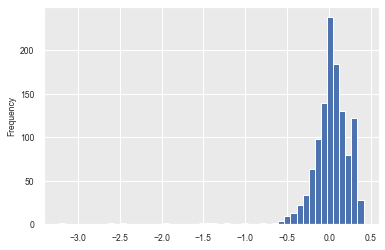

In [19]:
log10_diff = pd.np.log10(Y_orig / Y_national_median)
substantial_area = A > 50 * 1e-3 # * 1e3 for kha

log10_diff.reindex(substantial_area[substantial_area].index).plot.hist(bins=50)

In [20]:
log10_diff_limit = .75
too_large_diff = log10_diff.abs() > log10_diff_limit
suspect_case = too_large_diff & substantial_area

display(log10_diff[suspect_case])

suspect_geo_crop_combinations = suspect_case[suspect_case].index

geo   crops
DK0   G1000   -2.424239
EL    G1000   -3.221441
      G2000   -1.036244
EL1   G1000   -1.942465
ES24  G1000   -0.790852
ES4   C1120   -1.253528
ES41  C1120   -1.531119
ES42  C1120   -1.407636
IT    G1000   -2.615037
ITG   C1300   -0.805577
RO    G1000   -1.365825
Name: Y, dtype: float64

In [21]:
context_data = (
    eust
    .read_table_data('apro_cpshr')
    .value
    .reorder_levels(['geo', 'crops', 'time', 'strucpro'])
    .unstack()
    .assign(YI_calc=lambda d: d.PR_HU_EU / d.AR)
    .join(
        (
            eust.read_table_data('ef_lus_allcrops')
            .value
            .xs('HA', level='unit')
            .xs('TOTAL', level='agrarea')
            .mul(1e-3)
            .rename('MA (FSS)')
            .reorder_levels(['geo', 'crops', 'time'])
        ),
        how='left'
    )
    .round(2)
    .stack()
    .sort_index()
    .loc[:, :, 2010:2016]
)
correction_factors = {}

In [22]:
# Looks like DK0 G1000 is reported factor 1000 wrong for year 2013
display(context_data.loc['DK0', 'G1000'].unstack())
correction_factors['DK0', 'G1000', 2013] = 1e3

,AR,HU_EU,PR_HU_EU,YI_calc
time,,,,
2010,332.9,65.0,14150.40,42.51
2011,333.9,65.0,15660.00,46.90
2012,319.0,65.0,15783.30,49.48
2013,316.0,65.0,13.57,0.04
2014,320.1,65.0,14220.30,44.42
2015,NaN,65.0,NaN,NaN
2016,NaN,65.0,NaN,NaN


In [23]:
# Comparing Greece to Spain for reference
# Looks like EL G1000 might be reported factor 1000 wrong for years 2010-2014,
# and factor 100 wrong 2015-2016?
# Not sure, but this adjustment is probably better than nothing.
#
# EL G2000 yield is not obviously wrong, so let's leave it.
display(context_data.loc[['EL', 'EL1', 'ES'], 'G1000':'G2000'].unstack())
correction_factors['EL', 'G1000', 2013] = 1e3
correction_factors['EL1', 'G1000', 2013] = float('nan')

AR  HU_EU  PR_HU_EU  YI_HU_EU  YI_calc  MA (FSS)
geo crops time                                                      
EL  G1000 2010  118.58   65.0      1.84      0.01     0.02       NaN
          2011  114.44   65.0      2.57      0.02     0.02       NaN
          2012  105.25   65.0      2.01      0.02     0.02       NaN
          2013  111.08   65.0      0.75      0.01     0.01    110.92
          2014  121.85   65.0      1.81      0.01     0.01       NaN
          2015  111.12   65.0     20.71      0.19     0.19       NaN
          2016  109.83   65.0     14.02      0.13     0.13    123.06
    G2000 2010    9.07   65.0     37.40      4.12     4.12       NaN
          2011   11.61   65.0     73.93      6.37     6.37       NaN
          2012   11.23   65.0    126.21     11.24    11.24       NaN
          2013   15.76   65.0     88.41      5.61     5.61     58.74
          2014   13.59   65.0     61.71      4.54     4.54       NaN
          2015   19.07   65.0    111.74      5.86     5.86       NaN
          2016   25.97   65.0    141.72      5.46     5.46     90.61
EL1 G1000 2010  758.55   65.0     19.89       NaN     0.03       NaN
          2011  854.37   65.0     11.24       NaN     0.01       NaN
          2012  890.90   65.0      9.94       NaN     0.01       NaN
          2013  699.75   65.0      8.45       NaN     0.01       NaN
          2014  495.05   65.0     42.85       NaN     0.09       NaN
          2015     NaN   65.0       NaN       NaN      NaN       NaN
          2016     NaN   65.0       NaN       NaN      NaN       NaN
    G2000 2010    1.46   65.0     29.91       NaN    20.49       NaN
          2011    6.11   65.0     63.34       NaN    10.37       NaN
          2012    8.21   65.0    111.43       NaN    13.57       NaN
          2013   11.49   65.0     63.85       NaN     5.56       NaN
          2014   10.53   65.0     86.75       NaN     8.24       NaN
          2015     NaN   65.0       NaN       NaN      NaN       NaN
          2016     NaN   65.0       NaN       NaN      NaN       NaN
ES  G1000 2010  263.24   65.0   5995.79       NaN    22.78       NaN
          2011  279.18   65.0   5728.66       NaN    20.52       NaN
          2012  276.78    NaN       NaN       NaN      NaN       NaN
          2013  278.08    NaN       NaN       NaN      NaN    263.81
          2014  278.26    NaN       NaN       NaN      NaN       NaN
          2015  274.64   65.0   3882.32     14.14    14.14       NaN
          2016  289.47   65.0   4076.97     14.08    14.08    245.08
    G2000 2010  388.68   65.0   4700.40       NaN    12.09       NaN
          2011  380.96   65.0   4804.22       NaN    12.61       NaN
          2012  392.46   65.0   3817.90       NaN     9.73       NaN
          2013  379.54    NaN       NaN       NaN      NaN    160.23
          2014  396.06    NaN       NaN       NaN      NaN       NaN
          2015  412.15   65.0   7139.87     17.32    17.32       NaN
          2016  425.58   65.0   8350.15     19.62    19.62    212.09

In [24]:
# Nothing obviously wrong here. Probably just low harvests in ES4.
display(context_data.loc[['ES', 'ES4', 'ES41', 'ES42'], 'C1110':'C1120', 2013].unstack())

AR  HU_EU  MA (FSS)  PR_HU_EU  YI_HU_EU  YI_calc
geo  crops time                                                       
ES   C1110 2013  1781.58   14.0   1746.44   7088.86      3.91     3.98
     C1111 2013  1660.73   14.0       NaN   6492.53      3.91     3.91
     C1112 2013   120.86   14.0       NaN    573.02       NaN     4.74
     C1120 2013   343.39   14.0    539.03    976.56      2.68     2.84
ES4  C1110 2013  1191.95   14.0       NaN   4663.98       NaN     3.91
     C1111 2013  1084.23   14.0       NaN   4101.40       NaN     3.78
     C1112 2013      NaN   14.0       NaN       NaN       NaN      NaN
     C1120 2013     8.47   14.0       NaN     23.95       NaN     2.83
ES41 C1110 2013   818.08   14.0    792.38   3577.68       NaN     4.37
     C1111 2013   731.80   14.0       NaN   3088.24       NaN     4.22
     C1112 2013      NaN   14.0       NaN       NaN       NaN      NaN
     C1120 2013     1.38   14.0     57.44      5.67       NaN     4.11
ES42 C1110 2013   298.92   14.0    281.11    932.20       NaN     3.12
     C1111 2013   277.48   14.0       NaN    859.07       NaN     3.10
     C1112 2013      NaN   14.0       NaN       NaN       NaN      NaN
     C1120 2013     2.48   14.0     53.44      7.01       NaN     2.83

In [25]:
# Not sure what's wrong with the IT G1000 production value,
# but since subnational data are available let's drop the value
display(Y_orig.loc['IT', 'G1000'])
display(
    context_data
    .loc['IT':'ITX', ['G1000', 'G2000', 'G3000']]
    .unstack()
    .loc[lambda d: d[['AR', 'PR_HU_EU']].notnull().all(axis=1)]
    .loc[lambda d: d.index.get_level_values('geo').str.len() <= 3]
)
correction_factors['IT', 'G1000', 2013] = float('nan')

0.02421334190812468

AR  HU_EU  MA (FSS)  PR_HU_EU  YI_calc  YI_HU_EU
geo crops time                                                       
IT  G1000 2013   252.90   65.0   1024.95     28.00     0.11       NaN
          2016   807.19   65.0   1093.54  12329.60    15.27       NaN
    G2000 2016  1129.96   65.0    128.53  26760.00    23.68       NaN
    G3000 2010   282.58   65.0       NaN  14088.60    49.86     52.83
          2013   326.71   65.0    274.83  18423.66    56.39      9.38
          2014   342.74   65.0       NaN  22676.22    66.16      5.95
          2016   325.04   65.0    275.23  20423.98    62.84      5.55
          2011   297.45   65.0       NaN  15620.80    52.52      9.80
          2012   296.31   65.0       NaN  15151.40    51.13      9.80
ITC G1000 2016   120.03   65.0       NaN   3570.30    29.75       NaN
    G2000 2016   133.67   65.0       NaN   4777.70    35.74       NaN
    G3000 2016   196.05   65.0       NaN  12773.62    65.15       NaN
ITD G3000 2011    75.82   65.0       NaN   3959.20    52.22       NaN
ITE G3000 2011    29.43   65.0       NaN   1436.00    48.79       NaN
ITF G1000 2016   223.21   65.0       NaN   2230.30     9.99       NaN
    G2000 2016   221.97   65.0       NaN   3225.80    14.53       NaN
    G3000 2016    24.50   65.0       NaN   1321.60    53.94       NaN
ITG G1000 2016   281.24   65.0       NaN   2934.20    10.43       NaN
    G2000 2016   169.31   65.0       NaN   1949.40    11.51       NaN
    G3000 2016     7.92   65.0       NaN    262.08    33.09       NaN
          2011     9.31   65.0       NaN    292.90    31.46       NaN
ITH G1000 2016    36.93   65.0       NaN    739.70    20.03       NaN
    G2000 2016   308.96   65.0       NaN  11884.40    38.47       NaN
    G3000 2016    69.37   65.0       NaN   4419.15    63.70       NaN
ITI G1000 2016   145.78   65.0       NaN   2855.10    19.58       NaN
    G2000 2016   296.05   65.0       NaN   4922.70    16.63       NaN
    G3000 2016    27.20   65.0       NaN   1647.53    60.57       NaN

In [26]:
# Nothing obviously wrong with ITG C1300
display(
    context_data
    .loc['ITG':'ITHX', ['C1000', 'C1200', 'C1300']]
    .unstack()
    .loc[lambda d: d['AR'] > 1]
)

AR  HU_EU  PR_HU_EU  YI_calc  MA (FSS)
geo  crops time                                            
ITG  C1000 2010  392.45   14.0    985.33     2.51       NaN
           2011  378.92   14.0   1004.23     2.65       NaN
           2013   39.20   14.0     87.08     2.22       NaN
           2014  358.63   14.0    956.50     2.67       NaN
     C1300 2010   25.82   14.0     49.43     1.91       NaN
           2011   24.07   14.0     49.42     2.05       NaN
           2012   18.38   14.0     52.65     2.86       NaN
           2013   16.70   14.0     33.43     2.00       NaN
           2014   16.56   14.0     36.45     2.20       NaN
           2015   18.34   14.0     45.07     2.46       NaN
           2016   18.29   14.0     44.72     2.45       NaN
ITG1 C1000 2010  330.24   14.0    877.52     2.66       NaN
           2011  317.71   14.0    888.43     2.80       NaN
           2013   16.57   14.0     42.36     2.56       NaN
           2014  300.26   14.0    824.46     2.75       NaN
     C1300 2010   13.34   14.0     31.01     2.32       NaN
           2011   10.39   14.0     25.62     2.47       NaN
           2012    7.51   14.0     19.81     2.64       NaN
           2013    4.36   14.0     11.11     2.55     23.43
           2014    4.47   14.0     12.83     2.87       NaN
           2015    4.85   14.0     13.47     2.78       NaN
           2016    4.80   14.0     13.16     2.74     23.68
ITG2 C1000 2010   62.22   14.0    107.81     1.73       NaN
           2011   61.21   14.0    115.80     1.89       NaN
           2013   22.63   14.0     44.73     1.98       NaN
           2014   58.37   14.0    132.04     2.26       NaN
     C1300 2010   12.48   14.0     18.42     1.48       NaN
           2011   13.67   14.0     23.79     1.74       NaN
           2012   10.87   14.0     22.09     2.03       NaN
           2013   12.34   14.0     22.32     1.81     32.79
           2014   12.09   14.0     23.62     1.95       NaN
           2015   13.49   14.0     31.60     2.34       NaN
           2016   13.49   14.0     31.56     2.34     35.24
ITH  C1300 2015   39.51   14.0    225.08     5.70       NaN
           2016   42.75   14.0    255.09     5.97       NaN
ITH3 C1300 2015   12.64   14.0     77.37     6.12       NaN
           2016   16.69   14.0    104.36     6.25     40.26
ITH4 C1300 2015    5.76   14.0     30.55     5.30       NaN
           2016    6.00   14.0     30.70     5.12      8.86
ITH5 C1300 2015   21.05   14.0    116.96     5.56       NaN
           2016   20.00   14.0    119.79     5.99     20.46

In [27]:
# Looks like RO G1000 is a little strange; MA and AR don't match.
# But G2000 and G3000 are much more important in area here, so let's ignore this one.
display(
    context_data
    .loc['RO', 'G0000':'GX', 2012:2014]
    .unstack()
    .loc[lambda d: d['AR'] > 1]
)

AR  HU_EU      MA  MA (FSS)  PR_HU_EU  YI_HU_EU  YI_calc
geo crops time                                                              
RO  G0000 2012  874.37   65.0  873.20       NaN   5164.08      5.91     5.91
          2013  859.71   65.0  858.75    712.30   5771.24      6.71     6.71
          2014  859.60   65.0  858.49       NaN   6013.06      7.00     7.00
    G1000 2012   25.83   65.0     NaN       NaN     49.29      1.91     1.91
          2013   26.34   65.0     NaN    106.08     51.44      1.95     1.95
          2014   22.14   65.0     NaN       NaN     49.41      2.23     2.23
    G2000 2012  624.14   65.0     NaN       NaN   2071.27      3.32     3.32
          2013  625.51   65.0     NaN    484.25   2373.36      3.79     3.79
          2014  637.60   65.0     NaN       NaN   2574.08      4.04     4.04
    G2100 2012  338.14   65.0     NaN       NaN   1209.10      3.58     3.58
          2013  341.34   65.0     NaN       NaN   1370.13      4.01     4.01
          2014  361.80   65.0     NaN       NaN   1517.81      4.20     4.20
    G2900 2012  286.00   65.0     NaN       NaN    862.17      3.02     3.01
          2013  284.16   65.0     NaN       NaN   1003.23      3.53     3.53
          2014  275.80   65.0     NaN       NaN   1056.27      3.83     3.83
    G3000 2012   49.88   65.0     NaN       NaN    930.15     18.65    18.65
          2013   56.31   65.0     NaN     32.89   1259.93     22.38    22.37
          2014   48.27   65.0     NaN       NaN   1351.55     28.00    28.00
    G9100 2013    1.34   65.0     NaN       NaN     18.62     13.89    13.90
    G9900 2012  173.73   65.0     NaN       NaN   2105.75     12.12    12.12
          2013  150.22   65.0     NaN       NaN   2067.88     13.77    13.77
          2014  150.78   65.0     NaN       NaN   2024.12     13.42    13.42

## Apply the correction factors

In [28]:
Y_corrected = Y_orig.copy(deep=True)
H_corrected = H_orig.copy(deep=True)

for (geo, crop, year), factor in correction_factors.items():
    assert year == settings.DATA_YEAR
    Y_corrected.loc[geo, crop] *= factor
    H_corrected.loc[geo, crop] *= factor
    
display(Y_corrected[Y_corrected != Y_orig])
display(H_corrected[H_corrected != H_orig])

geo  crops
DK0  G1000    37.571009
EL   G1000     5.993090
EL1  G1000          NaN
IT   G1000          NaN
Name: Y, dtype: float64

geo  crops
DK0  G1000    12.027607
EL   G1000     0.664754
EL1  G1000          NaN
IT   G1000          NaN
Name: H, dtype: float64

## Set unproductive crops' yields to 0

This is just a computational convenience. We're interested in the average productivity on the reference area. If these "crops" (fallow and unused grassland) are included in the reference area, then their lack of production should be included in the mean.

In [29]:
NON_PRODUCTIVE_CROPS = ['Q0000', 'J3000']
NON_PRODUCTIVE_CROPS

['Q0000', 'J3000']

## Copy yield down to subregions where values are missing

In [30]:
Y_filled = (
    Y_corrected
    .unstack()
    .assign(**{k: 0 for k in NON_PRODUCTIVE_CROPS})
    .stack()
    .pipe(
        hierarchy.fill_copy_to_children,
        nuts.get_nuts_aggregates(),
        level='geo',
        iterate=True
    )
    .sort_index()
)
Y_filled

geo   crops
AT    C1100    16.630838
      C1110    16.617218
      C1120    16.968875
      C1200    12.421926
      C1300    15.737268
                 ...    
UKN0  J2000    18.786477
      J3000     0.000000
      Q0000     0.000000
      R1000    26.661473
      R2000    34.616746
Length: 6956, dtype: float64

## Calculate gap-filled P harvest data

* This will equal the previous result where there is harvest data.
* Where harvest data are missing but areas available, it creates an estimate corresponding to the assumption that yields are the same as in the parent region.
* Where areas are zero, harvests can be assumed zero too.
* Finally, harvests are summed to parent regions and crops if all children are available.

In [31]:
def append_additional(s, additions):
    additions = additions.dropna()
    return s.append(
        additions.reindex(additions.index.difference(s.index))
    )

H_filled = (
    H_corrected
    .pipe(append_additional, Y_filled.mul(A))
    .pipe(append_additional, A[A == 0]) # where area is 0 it is equal to harvest
    .pipe(fill_nuts_crops_iter)
    .dropna()
    .sort_index()
)

H_filled.round(1)

INFO:__main__:Original length 16213
INFO:__main__:Filled 198 using NUTS hierarchy
INFO:__main__:Filled 1611 using crop hierarchy
INFO:__main__:Filled 0 using NUTS hierarchy
INFO:__main__:Filled 0 using crop hierarchy


geo  crops     
AT   C0000         13.4
     C1000         13.4
     C1000X1500     9.1
     C1100          4.9
     C1110          4.8
                   ... 
XK   G9100          0.0
     G9900          0.0
     I1120          0.0
     R1000          0.0
     W1000          0.0
Length: 18021, dtype: float64

## Find the most aggregated set of available crops for each region

In [32]:
def take_highest(d, aggregates, labels):
    index = d.index
    assert index.nlevels == 1, index.nlevels
    assert len(index.names) == 1, index.names
    candidates = set(labels)
    results = set()
    while candidates:
        found = candidates & set(index)        
        results.update(found)
        
        not_found = candidates - found
        candidates = set()
        for item in not_found:
            if item in aggregates:
                children = aggregates[item]
                candidates.update(children)
            else:
                results.add(item)
        results.update(found)
    return d.reindex(index.intersection(results))


In [33]:
crop_data = (
    pd.DataFrame({
        'A': A,
        'a': A.div(A.xs('UAA', level='crops'), axis=0),
        'H': H_filled
    })
    .rename_axis('variable', axis=1)
    .reindex(['a', 'A', 'H'], axis=1)
    .dropna(how='all')
)
crop_data

variable               a        A          H
geo crops                                   
AT  ARA         0.500152  1.36386        NaN
    ARA99       0.001687  0.00460        NaN
    C0000       0.301292  0.82159  13.365370
    C1000       0.301292  0.82159  13.365370
    C1000X1500  0.215608  0.58794   9.136698
...                  ...      ...        ...
XK  G9100            NaN      NaN   0.009712
    G9900            NaN      NaN   0.023275
    I1120            NaN      NaN   0.002730
    R1000            NaN      NaN   0.033270
    W1000            NaN      NaN   0.005520

[31635 rows x 3 columns]

In [34]:
most_aggregated_crop_data = (
    crop_data
    .dropna(how='any')
    .groupby(level='geo')
    .apply(lambda d: take_highest(d.droplevel('geo'), CROP_PARTITIONS, INCLUDED_CROPS))
    .rename_axis(crop_data.index.names)
)
most_aggregated_crop_data

variable                a        A         H
geo  crops                                  
AT   C1000X1500  0.215608  0.58794  9.136698
     C1500       0.085684  0.23365  4.228672
     C2000       0.000000  0.00000  0.000000
     G0000       0.088977  0.24263  5.279267
     I1110       0.020995  0.05725  1.307542
...                   ...      ...       ...
UKN0 Q0000       0.000382  0.00040  0.000000
     R1000       0.004349  0.00455  0.121310
     R2000       0.000000  0.00000  0.000000
     T0000       0.000000  0.00000  0.000000
     W1000       0.000000  0.00000  0.000000

[7586 rows x 3 columns]

## Check area coverage on NUTS 0/1/2 levels

In [35]:
uaa_by_country = A.xs('UAA', level='crops').reindex(EU28_COUNTRIES)
uaa_by_country

geo
AT     2.72689
BE     1.30790
BG     4.65094
CY     0.10933
CZ     3.49147
DE    16.69958
DK     2.61934
EE     0.95751
EL     4.85678
ES    23.30022
FI     2.25763
FR    27.73943
HR     1.57120
HU     4.65652
IE     4.95945
IT    12.09889
LT     2.86125
LU     0.13104
LV     1.87772
MT     0.01088
NL     1.84757
PL    14.40987
PT     3.64159
RO    13.05585
SE     3.02862
SI     0.48576
SK     1.90161
UK    17.09617
dtype: float64

In [36]:
def get_covered_area(nuts_level):
    covered_items = most_aggregated_crop_data.dropna(how='any')
    
    return (
        covered_items
        .pipe(nuts.filter_nuts_level, nuts_level)
        .join(NUTS_TABLE.country_code)
        .groupby('country_code')
        .sum()
        .A
    )

coverage = (
    pd.DataFrame({
        nuts_level: get_covered_area(nuts_level)
        for nuts_level in [0, 1, 2]
        },
    )
    .div(uaa_by_country, axis=0)
    .round(2)
)
coverage.columns.name = 'nuts_level'
coverage

nuts_level,0,1,2
country_code,,,
AT,0.97,0.94,0.96
BE,0.93,0.91,0.92
BG,0.97,0.96,0.96
CY,0.88,0.88,0.88
CZ,0.97,0.97,0.94
DE,0.94,0.94,0.94
DK,0.92,0.92,0.92
EE,0.81,0.81,0.81
EL,0.90,0.89,0.89


In [37]:
COVERAGE_WARNING_BELOW = 0.8

coverage[(coverage < COVERAGE_WARNING_BELOW).any(axis=1)]

nuts_level,0,1,2
country_code,,,
IT,0.76,0.70,0.76
LV,0.78,0.78,0.78
MT,0.68,0.68,0.68
NL,0.79,0.78,0.79


In [38]:
final_crop_data = most_aggregated_crop_data.dropna()
final_crop_data.round(2)

variable            a     A     H
geo  crops                       
AT   C1000X1500  0.22  0.59  9.14
     C1500       0.09  0.23  4.23
     C2000       0.00  0.00  0.00
     G0000       0.09  0.24  5.28
     I1110       0.02  0.06  1.31
...               ...   ...   ...
UKN0 Q0000       0.00  0.00  0.00
     R1000       0.00  0.00  0.12
     R2000       0.00  0.00  0.00
     T0000       0.00  0.00  0.00
     W1000       0.00  0.00  0.00

[7586 rows x 3 columns]

## Save final crop data

In [39]:
final_crop_data.to_csv(settings.CROP_DATA_PATH)

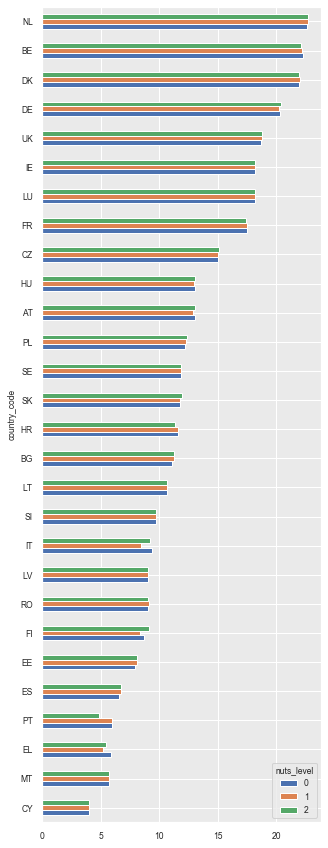

In [40]:
P_harvest_per_ha_by_country = (
    final_crop_data
    [['A', 'H']]
    .join(NUTS_TABLE[['country_code', 'nuts_level']], how='inner')
    .groupby(['country_code', 'nuts_level'])
    .sum()
    .eval('H/A')
    .rename('Y')
)

P_harvest_per_ha_by_country.unstack().sort_values(0).plot.barh(figsize=(5, 15))

# Calculate reference areas

In [41]:
# crops to exclude for each alternative
REFAREA_OPTIONS = {
    'UAA': [],
    'UAA_XJ2000_J3000': ['J2000', 'J3000'],
}

def calculate_refarea(excluded_crops):
    uaa = A.xs('UAA', level='crops').dropna()
    if not excluded_crops:
        return uaa
    excluded_area = (
        final_crop_data.A
        .reindex(excluded_crops, level='crops')
        .groupby('geo')
        .sum(skipna=False)
    )
    return uaa - excluded_area

refareas = pd.DataFrame({k: calculate_refarea(v) for k, v in REFAREA_OPTIONS.items()})
refareas

,UAA,UAA_XJ2000_J3000
geo,,
AT,2.72689,2.28822
AT1,1.09884,1.08506
AT11,0.18197,0.17671
AT12,0.90885,0.90100
AT13,0.00802,0.00735
...,...,...
UKM3,0.79834,0.48694
UKM5,0.47877,0.31144
UKM6,2.76356,0.43391


## Save reference areas

In [42]:
refareas.to_csv(settings.REFERENCE_AREAS_PATH)

# Calculate and save harvest for each reference area

In [43]:
def filter_excluded_crops(data, excluded_crops):
    return (
        data
        .loc[lambda s: ~s.index.get_level_values('crops').isin(excluded_crops)]
    )    

In [44]:
def get_productive_area(excluded_crops):
    return (
        final_crop_data
        .A
        .loc[lambda s: ~s.index.get_level_values('crops').isin(NON_PRODUCTIVE_CROPS)]
        .pipe(filter_excluded_crops, excluded_crops)
        .groupby('geo')
        .sum()
    )

In [45]:
def get_covered_area(excluded_crops):
    return (
        final_crop_data
        .A
        .pipe(filter_excluded_crops, excluded_crops)
        .groupby('geo')
        .sum()
    )

In [46]:
def get_explicit_harvest(excluded_crops):
    return (
        final_crop_data
        .H
        .pipe(filter_excluded_crops, excluded_crops)
        .groupby('geo')
        .sum()
    )

In [47]:
explicit_harvests = pd.DataFrame(
    {
        k: get_explicit_harvest(v)
        for k, v in REFAREA_OPTIONS.items()
    }
)
explicit_harvests

,UAA,UAA_XJ2000_J3000
geo,,
AT,34.371050,30.477182
AT1,14.244218,14.136066
AT11,2.229840,2.196879
AT12,13.128240,13.063995
AT13,0.077170,0.074235
...,...,...
UKM3,12.725890,6.898058
UKM5,6.859942,3.739050
UKM6,49.814136,6.115636


In [48]:
productive_areas = pd.DataFrame(
    {
        k: get_productive_area(v)
        for k, v in REFAREA_OPTIONS.items()
    }
)
productive_areas

,UAA,UAA_XJ2000_J3000
geo,,
AT,2.59693,2.16154
AT1,0.96442,0.95145
AT11,0.16375,0.15870
AT12,0.83940,0.83209
AT13,0.00623,0.00562
...,...,...
UKM3,0.67703,0.36688
UKM5,0.36575,0.19966
UKM6,2.65197,0.32639


In [49]:
covered_areas = pd.DataFrame(
    {
        k: get_covered_area(v)
        for k, v in REFAREA_OPTIONS.items()
    }
)
covered_areas

,UAA,UAA_XJ2000_J3000
geo,,
AT,2.63868,2.20001
AT1,0.99374,0.97996
AT11,0.17008,0.16482
AT12,0.86209,0.85424
AT13,0.00653,0.00586
...,...,...
UKM3,0.67872,0.36732
UKM5,0.37064,0.20331
UKM6,2.65735,0.32770


## Check coverage of UAA for each region

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6ace65eb8>,
      dtype=object)

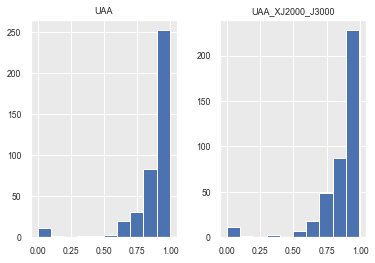

In [50]:
covered_fractions = covered_areas / refareas
covered_fractions.hist()

In [51]:
covered_fractions.loc[lambda d: (d < 0.5).any(axis=1)]

,UAA,UAA_XJ2000_J3000
geo,,
FR91,0.022610,0.022610
FR92,0.041787,0.041787
FR93,0.175268,0.175268
FR94,0.039810,0.039810
MK00,0.000000,0.000000
NO,0.309081,0.309081
NO01,0.000000,0.000000
NO02,0.000000,0.000000
NO03,0.000000,0.000000


In [52]:
mean_productive_yields = explicit_harvests / productive_areas
mean_productive_yields

,UAA,UAA_XJ2000_J3000
geo,,
AT,13.235262,14.099754
AT1,14.769725,14.857393
AT11,13.617346,13.842969
AT12,15.640028,15.700218
AT13,12.386823,13.209050
...,...,...
UKM3,18.796642,18.801947
UKM5,18.755823,18.727088
UKM6,18.783823,18.737204


In [53]:
implicit_harvests = (1 - covered_fractions) * mean_productive_yields * refareas

In [54]:
refarea_harvests = explicit_harvests + implicit_harvests
refarea_harvests

,UAA,UAA_XJ2000_J3000
geo,,
AT,35.538532,31.720921
AT1,15.796516,15.697578
AT11,2.391751,2.361472
AT12,13.859568,13.798137
AT13,0.095626,0.093916
...,...,...
UKM3,14.974345,9.147147
UKM5,8.888009,5.764010
UKM6,51.809166,8.105715


In [55]:
mean_yields = refarea_harvests / refareas

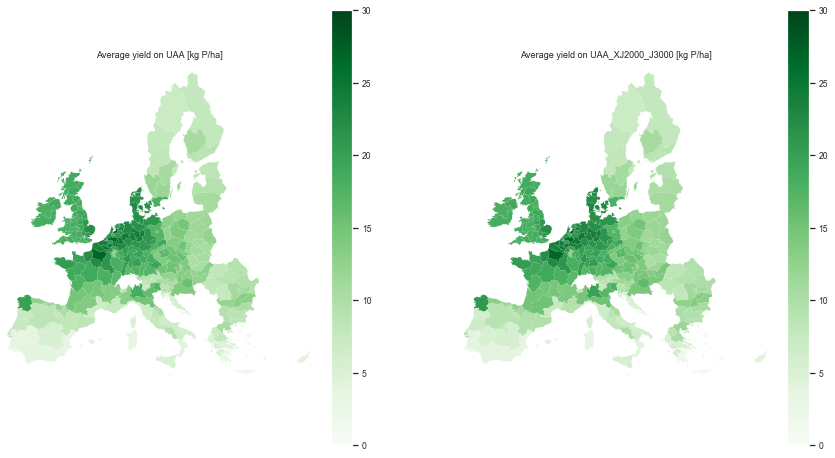

In [56]:
nuts_geo = geopandas.read_file(settings.NUTS_GIS_PATH).set_index('NUTS_ID')
fig, axs = plt.subplots(ncols=len(mean_yields.columns))

for col, ax in zip(mean_yields.columns, axs):
    (
        nuts_geo
        .join(mean_yields[col], how='inner')
        .pipe(nuts.filter_nuts_level, 2)
        .plot(col, legend=True, cmap=mpl.cm.Greens, vmin=0, vmax=30, ax=ax, lw=0)
    )
    plotting.adj_geoplot(ax)
    ax.set_title(f'Average yield on {col} [kg P/ha]')
fig.set_size_inches(15, 8)

In [57]:
refarea_harvests.to_csv(settings.HARVEST_PATH)